## PHYS-F-302 : Mécanique Quantique, partie numérique

Aurélien Manera
Florian Danneau

Nous allons décrire le flux de Stokes dans une cavitée carrée en résolvant une équation biharmonique. Le flux de Stokes nous permet de simplifier les équations de Navier-Stokes, en éliminant la non-linéarité. 

Il faut tout d'abord discétiser une équation biharmonique :

\begin{equation}
\nabla^{4}\psi = 0
\end{equation}


On a donc :

\begin{equation}
\nabla^{2}(\nabla^{2}\psi) = 0
\end{equation}

\begin{equation}
\partial_{x}^{4}\psi + \partial_{y}^{4}\psi + 2\partial_{x}\partial_{y}\psi = 0 
\end{equation}

Maintenant, nous allons la discrétiser :
    
\begin{equation}
\partial_{x}^{4}\psi = \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}}
\end{equation}

\begin{equation}
\partial_{y}^{4}\psi = \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}}
\end{equation}

\begin{equation}
\partial_{x}^{2}\partial_{y}^{2}\psi = \dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}} 
\end{equation}

\begin{equation}
\nabla^{4}\psi = \dfrac{\psi[i-2,j]-4\psi[i-1,j] + 6\psi[i,j]-4\psi[i+1,j]+ \psi[i+2,j]}{dx^{4}} + \dfrac{\psi[i,j-2]-4\psi[i,j-1] + 6\psi[i,j]-4\psi[i,j+1]+ \psi[i,j+2]}{dy^{4}}+ 2\dfrac{\psi[i-1,j+1]-2\psi[i,j+1] + \psi[i+1,j+1]-2\psi[i-1,j]+ 4\psi[i,j]-2\psi[i+1,j]+\psi[i-1,j-1]-2\psi[i,j-1]+\psi[i+1,j-1]}{dx^{2}dy^{2}} = 0
\end{equation}

Où nous avons utilisé le lien suivant pour trouver les coefficients :
https://en.wikipedia.org/wiki/Finite_difference_coefficient

Nous importons ce dont nous avons besoin pour résoudre notre problème.

In [1]:
import matplotlib.pyplot as plt
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
from math import pi, cos, sin
%matplotlib inline
from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

On va également utiliser les paramètres de discrétisation donné dans le MOOC.

In [2]:

nx = 41
ny = 41

l = 1.
h = 1.

dx = l/(nx-1)
dy = h/(ny-1)

l1_target = 1e-8

x  = numpy.linspace(0,l,nx)
y  = numpy.linspace(0,h,ny)
X,Y = numpy.meshgrid(x,y)

b = numpy.zeros((nx,ny))

p_i = numpy.zeros((nx,ny))

print(p_i)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [3]:
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

Pour implémenter nos conditions aux bords, nous allons d'abord les discértiser à l'aide du lien wikipédia.

On a donc que :

\begin{equation}
\partial_{x} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i+1,j] \dfrac{-1}{2} \psi[i+2,j]}{dx}
\end{equation}

\begin{equation}
\partial_{y} \psi = \dfrac{\dfrac{-3}{2}\psi[i,j] + 2\psi[i,j+1] \dfrac{-1}{2} \psi[i,j+2]}{dy}
\end{equation}


Dès lors, on peut implémenter nos conditions aux bords comme suit :

In [31]:
cond1 = ((-3/2)*p_i[0,:] + 2*p_i[1,:] -(1/2)*p_i[2,:])/dx ==0
cond2 = ((-3/2)*p_i[-1,:] + 2*p_i[0,:] -(1/2)*p_i[1,:])/dx ==0
cond3 = ((-3/2)*p_i[:,0] + 2*p_i[:,1] -(1/2)*p_i[:,2])/dy ==0
cond4 = ((-3/2)*p_i[:,-1] + 2*p_i[:,0] -(1/2)*p_i[:,1])/dy ==1

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  1.  1.  0.]
 [ 0.  1.  1. ...,  1.  1.  0.]
 ..., 
 [ 0.  1.  1. ...,  1.  1.  0.]
 [ 0.  1.  1. ...,  1.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [15]:

p_i[1,:] = (3/4)*p_i[0,:] + (1/4)*p_i[2,:] #forward
p_i[-2,:] = (3/4)*p_i[-1,:] + (1/4)*p_i[-3,:] #backward
p_i[:,1] = (3/4)*p_i[:,0] + (1/4)*p_i[:,2] #forward
p_i[:,-2] = (1/4)*p_i[:,-3] + (3/4)*p_i[:,-1] - (dy/2) #backward
p_i[0,:] = 0
p_i[-1,:] = 0
p_i[:,0] = 0
p_i[:,-1] = 0
print(p_i)

[[ 0.      0.      0.     ...,  0.      0.      0.    ]
 [ 0.      0.      0.     ...,  0.     -0.0125  0.    ]
 [ 0.      0.      0.     ...,  0.     -0.0125  0.    ]
 ..., 
 [ 0.      0.      0.     ...,  0.     -0.0125  0.    ]
 [ 0.      0.      0.     ...,  0.     -0.0125  0.    ]
 [ 0.      0.      0.     ...,  0.      0.      0.    ]]


On doit utiliser la méthode des gradients qui est donnée explicitement dans le mooc, pour résoudre l'équation.

In [16]:
def L2_rel_error(p, pn): 
     ''' Compute the relative L2 norm of the difference 
     Parameters: 
     ---------- 
     p : array of float 
         array 1 
     pn: array of float 
         array 2 
     Returns: 
    ------- 
     Relative L2 norm of the difference 
     ''' 
     
     return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2)) 

In [45]:
def conjugate_gradient_2d(p, b, dx, dy, l2_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l2_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    ny, nx = p.shape
    r  = numpy.zeros((ny,nx)) # residual
    Ad  = numpy.zeros((ny,nx)) # to store result of matrix multiplication 
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    r[2:-2,2:-2] = b[2:-2,2:-2] - (1*p[2:-2,:-4]+ 2*p[1:-3,1:-3]-8*p[2:-2,1:-3]+2*p[3:-1,1:-3]+1*p[:-4,2:-2]-8*p[1:-3,2:-2] +20*p[2:-2,2:-2]-8*p[3:-1,2:-2] +1*p[4:,2:-2]+2*p[1:-3,3:-1]-8*p[2:-2,3:-1]+2*p[3:-1,3:-1]+1*p[2:-2,4:])/dx**4
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad[2:-2,2:-2] = (+1)*(1*d[2:-2,:-4]+ 2*d[1:-3,1:-3]-8*d[2:-2,1:-3]+2*d[3:-1,1:-3]+1*d[:-4,2:-2]-8*d[1:-3,2:-2] +20*d[2:-2,2:-2]-8*d[3:-1,2:-2] +1*d[4:,2:-2]+2*d[1:-3,3:-1]-8*d[2:-2,3:-1]+2*d[3:-1,3:-1]+1*d[2:-2,4:])/dx**4
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l2_norm > l2_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad[2:-2,2:-2] = (+1)*(1*d[2:-2,:-4]+ 2*d[1:-3,1:-3]-8*d[2:-2,1:-3]+2*d[3:-1,1:-3]+1*d[:-4,2:-2]-8*d[1:-3,2:-2] +20*d[2:-2,2:-2]-8*d[3:-1,2:-2] +1*d[4:,2:-2]+2*d[1:-3,3:-1]-8*d[2:-2,3:-1]+2*d[3:-1,3:-1]+1*d[2:-2,4:])/dx**4
        sigma = numpy.sum(d*Ad)
        
        # BCs are automatically enforced
        
        l2_norm = L2_rel_error(pk,p)
        iterations += 1
        l2_conv.append(l2_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l2_conv     

In [46]:
p, l1_conv = conjugate_gradient_2d(p_i.copy(), b, dx, dy, l1_target)

Number of CG iterations: 613


In [47]:
print(p)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.25000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   9.26966030e-07 ...,  -7.85789397e-03
   -1.25000000e-02   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   9.26933541e-07 ...,  -7.85789395e-03
   -1.25000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
   -1.25000000e-02   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


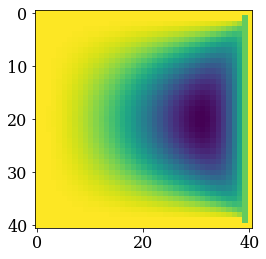

In [48]:
plt.imshow(p)

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.6)?

In [49]:
p[24,24]

-0.038459941705737147

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.2)?

In [50]:
p[24,8]

-0.0047040987714494506

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.4)?

In [51]:
p[24,16]

-0.018196223439538597

Quelle est la valeur de la fonction de flux $\psi$ en (0.6;0.8)?

In [52]:
p[24,32]

-0.05054146923237994

En conclusion, nous avons résolu notre problème, càd décrire le flux de Stokes dans une cavité carré.